In [1]:
# Needed for functions
import numpy as np
from matplotlib import pyplot as plt
import time
from IPython.display import display, clear_output

# Qiskit imports
import qiskit
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, schedule, assemble, execute
from qiskit.tools.monitor import job_monitor
import qiskit.tools.jupyter

# Interleaved randomized benchmarking functions
from qiskit.ignis.verification import randomized_benchmarking as rb
from qiskit.ignis.verification import InterleavedRBFitter

# Measurement mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator

# Qiskit Pulse imports
import qiskit.pulse
from qiskit import pulse
from qiskit.pulse import library

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
# backend = provider.get_backend('ibmq_lima')

In [3]:
backend = QasmSimulator.from_backend(provider.get_backend('ibmq_lima'))

In [4]:
qc = qiskit.QuantumCircuit(2)
qc.swap(0, 1)
qc.measure_all()
job = execute(qc, shots=20000, backend=backend)
job.result().get_counts()

{'11': 36, '10': 212, '00': 19515, '01': 237}

In [5]:
(210+36+181)/20000

0.02135

In [6]:
backend.configuration().coupling_map

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]

In [7]:
coupling_map = backend.configuration().coupling_map
gate_errors_cx = [backend.properties().gate_error('cx', qubit_pair) for qubit_pair in coupling_map]

for qubit_pair, gate_error_cx in zip(coupling_map, gate_errors_cx):
    print("Qubit pair {} has cx error {:.4f}".format(qubit_pair, gate_error_cx))
    
best_cx_error = min(gate_errors_cx)
best_qubit_pair = coupling_map[gate_errors_cx.index(min(gate_errors_cx))]
print("Best cx gate is qubit pair {} with cx error {:.4f} ({:.2f}%)".format(best_qubit_pair, best_cx_error, best_cx_error*100))

Qubit pair [0, 1] has cx error 0.0043
Qubit pair [1, 0] has cx error 0.0043
Qubit pair [1, 2] has cx error 0.0052
Qubit pair [1, 3] has cx error 0.0116
Qubit pair [2, 1] has cx error 0.0052
Qubit pair [3, 1] has cx error 0.0116
Qubit pair [3, 4] has cx error 0.0165
Qubit pair [4, 3] has cx error 0.0165
Best cx gate is qubit pair [0, 1] with cx error 0.0043 (0.43%)


In [8]:
# do RB on swap gate between the qubits that have the cx gate with lowest error
q1 = best_qubit_pair[0]
q2 = best_qubit_pair[1]

# generate the RB circuit parameters
length_vector = np.arange(1,200,20)
nseeds = 5
rb_pattern = [[q1,q2]]

In [9]:
# Specify the interleaved element, i.e. the gate to be characterized
qc_swap = QuantumCircuit(2)

### YOUR CODE GOES HERE -- START

qc_swap.swap(0, 1)

### YOUR CODE GOES HERE -- FINISH

interleaved_elem = [qc_swap]

In [10]:
# Generate the RB circuits
rb_circs, xdata, circuits_interleaved = rb.randomized_benchmarking_seq(length_vector=length_vector,
                                                                       nseeds=nseeds,
                                                                       rb_pattern=rb_pattern,
                                                                       interleaved_elem=interleaved_elem)

In [11]:
rb_circs[0][0].draw()

┌─────┐┌───┐     ┌─────┐┌───┐      ░       ┌───┐ ┌───┐     ┌───┐┌───┐┌─┐
qr_0: ┤ Sdg ├┤ H ├──■──┤ Sdg ├┤ H ├──■───░───■───┤ H ├─┤ S ├──■──┤ H ├┤ S ├┤M├
      └┬───┬┘└───┘┌─┴─┐└┬───┬┘├───┤┌─┴─┐ ░ ┌─┴─┐┌┴───┴┐├───┤┌─┴─┐├───┤└┬─┬┘└╥┘
qr_1: ─┤ Z ├──────┤ X ├─┤ H ├─┤ S ├┤ X ├─░─┤ X ├┤ Sdg ├┤ H ├┤ X ├┤ Z ├─┤M├──╫─
       └───┘      └───┘ └───┘ └───┘└───┘ ░ └───┘└─────┘└───┘└───┘└───┘ └╥┘  ║ 
cr: 2/══════════════════════════════════════════════════════════════════╩═══╩═
                                                                        1   0

In [12]:
circuits_interleaved[0][0].draw()

┌─────┐┌───┐     ┌─────┐┌───┐      ░     ░      ┌─────┐┌───┐     ┌─┐   
qr_0: ┤ Sdg ├┤ H ├──■──┤ Sdg ├┤ H ├──■───░──X──░───■──┤ Sdg ├┤ H ├─────┤M├───
      └┬───┬┘└───┘┌─┴─┐└┬───┬┘├───┤┌─┴─┐ ░  │  ░ ┌─┴─┐├─────┤├───┤┌───┐└╥┘┌─┐
qr_1: ─┤ Z ├──────┤ X ├─┤ H ├─┤ S ├┤ X ├─░──X──░─┤ X ├┤ Sdg ├┤ H ├┤ Z ├─╫─┤M├
       └───┘      └───┘ └───┘ └───┘└───┘ ░     ░ └───┘└─────┘└───┘└───┘ ║ └╥┘
cr: 2/══════════════════════════════════════════════════════════════════╩══╩═
                                                                        0  1

In [13]:
# Execute the non-interleaved RB circuits as a reference 
shots=1000
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
result_list = []
transpile_list = []

for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = execute(rb_circ_transpile, shots=shots, backend=backend)
    job_monitor(job)
    result_list.append(job.result())
    transpile_list.append(rb_circ_transpile)  
    
print("Finished Simulating")

Compiling seed 0
Simulating seed 0
Job Status: job has successfully run
Compiling seed 1
Simulating seed 1
Job Status: job has successfully run
Compiling seed 2
Simulating seed 2
Job Status: job has successfully run
Compiling seed 3
Simulating seed 3
Job Status: job has successfully run
Compiling seed 4
Simulating seed 4
Job Status: job has successfully run
Finished Simulating


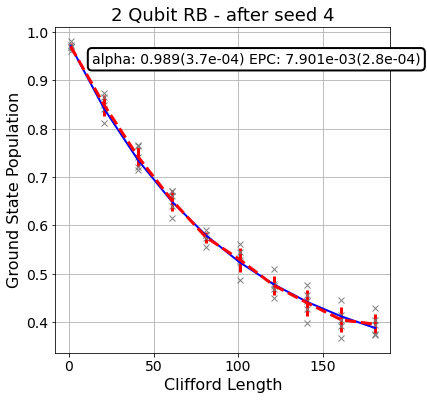

In [14]:
# Plot the non-interleaved RB results
rbfit = rb.fitters.RBFitter(result_list[0], xdata, rb_pattern)

for seed_num, data in enumerate(result_list):#range(1,len(result_list)):  
    plt.figure(figsize=(6, 6))
    axis = [plt.subplot(1, 1, 1)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(1):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('2 Qubit RB - after seed %d'%(seed_num), fontsize=18)
        
    # Display
    display(plt.gcf())
    
    # Clear display after each seed and close
    clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

In [15]:
# Execute the interleaved RB circuits
shots=1000
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
interleaved_result_list = []
interleaved_transpile_list = []
for rb_seed,rb_circ_seed in enumerate(circuits_interleaved):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = execute(rb_circ_transpile, shots=shots, backend=backend)
    interleaved_result_list.append(job.result())
    interleaved_transpile_list.append(rb_circ_transpile)    
print("Finished Simulating")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating


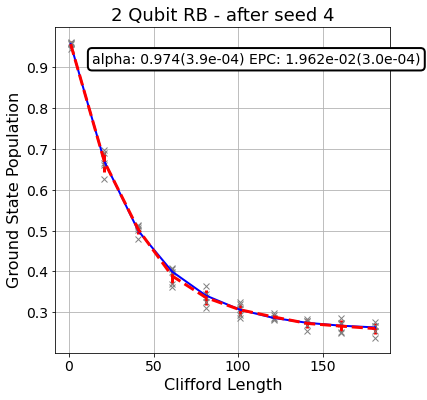

In [16]:
# Plot the interleaved RB circuit results
rbfit = rb.fitters.RBFitter(interleaved_result_list[0], xdata, rb_pattern)

for seed_num, data in enumerate(interleaved_result_list):#range(1,len(result_list)):  
    plt.figure(figsize=(6, 6))
    axis = [plt.subplot(1, 1, 1)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(1):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('2 Qubit RB - after seed %d'%(seed_num), fontsize=18)
        
    # Display
    display(plt.gcf())
    
    # Clear display after each seed and close
    clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

In [17]:
# Extract the interleaved results and plot
rb_fit_interleaved = InterleavedRBFitter(result_list, interleaved_result_list, xdata, rb_pattern)

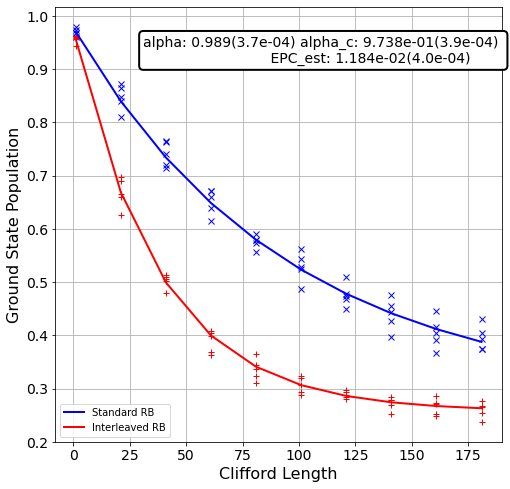

In [18]:
plt.figure(figsize=(8, 8))
axis = [plt.subplot(1, 1, 1)]
rb_fit_interleaved.plot_rb_data(ax=axis[0],add_label=True, show_plt=False)